# Sparse Attention

## Handle 1 head, 1 batch

Short:
- m: sequence lengh
- h: one token's dimention
- k: one token is related with multiple previous k tokens

Shapes:
- query: [m, h], to be [m, 1, h]
- key: [m, k, h]
- value: [m, k, h]
- output: [m, h]

Steps:
1. generate masks [m, m] and it's sparse
2. gather keys and values based on masks
3. calc

## Handle multiple heads and multiple batches

TODO

In [37]:
import numpy as np
import tensorflow as tf
import math

import seaborn
import matplotlib.pyplot as plt

b = 128
m = 1024
h = 64
heads = 1
x = np.random.normal(0, 1, [b, m, h])
print(x.shape)

(128, 1024, 64)


In [34]:
def mask(n, start_n, local_n, heads, m, batch_size):
    rand_n = n - start_n - local_n
    adjacents = []
    for idx_head in range(heads):
        adjacent = []
        for i in range(m):
            # generate <=k ones, like BigBird but sequence masked, it has local, start and random
            optin = set()
            # local including self
            for j in range(i+1 - local_n, i+1):
                if j>=0:
                    optin.add(j)
            # start
            for j in range(0, start_n):
                if j < i:
                    optin.add(j)
            # rand
            while len(optin) < min(i+1, n):
                js = np.random.randint(low=0, high=i+1, size=rand_n)
                for j in js:
                    if len(optin) < min(i+1, n):
                        optin.add(j)
            # output for gather
            optin = list(optin)
            optin_repeated = optin * (n // len(optin))
            # local first padding
            optin_repeated += optin[len(optin) - (n-len(optin_repeated)):]
            adjacent.append(optin_repeated)
        adjacents.append(adjacent)
    adjacents = [adjacents] * batch_size
    adjacents = np.array(adjacents)
    return adjacents

adjacents = mask(n= m//4, start_n=4, local_n=8, heads=heads, m=m, batch_size=b)

In [35]:
print(x.shape)
print(adjacents.shape)
adjacents = tf.squeeze(adjacents, axis=1)
print(adjacents.shape)

(128, 1024, 64)
(128, 1, 1024, 256)
(128, 1024, 256)


In [36]:
# seaborn.heatmap(data=mask, cbar=False, annot=False)
# plt.show()

q = tf.expand_dims(x, axis=1)
k = tf.gather(x, adjacents, batch_dims=1)
print(q.shape, k.shape)
aw = tf.einsum('bomh,bmnh->bmn', q, k)
print(aw.shape)
aw = aw / (h ** 0.5)
aw = tf.nn.softmax(aw)
atten = tf.einsum('bmn,bmnh->bmh', aw, k)
print(atten.shape)

(128, 1, 1024, 64) (128, 1024, 256, 64)
(128, 1024, 256)
(128, 1024, 64)


# Attention Free Transformer

In [129]:
b = 256
m = 128
h = 64
x = np.random.normal(0, 1, [b, m, h])

w_q = np.random.normal(0, 1, [h, h])
w_k = np.random.normal(0, 1, [h, h])
w_v = np.random.normal(0, 1, [h, h])
w_p = np.random.normal(0, 1, [h, h])
w_b = np.random.normal(0, 1, [m, m])

# q = np.matmul(x, w_q)
# k = np.matmul(x, w_k)
# v = np.matmul(x, w_v)

q = x
k = x
v = x

In [130]:
b = tf.expand_dims(w_b, axis=0)

b_exp = tf.math.exp(b)
k_exp = tf.math.exp(k)
k_exp_v = tf.math.multiply(tf.math.exp(k), v)
y = tf.math.multiply(
    tf.sigmoid(q),
    tf.matmul(b_exp, k_exp_v) / tf.matmul(b_exp, k_exp))
out = tf.matmul(y, w_p)

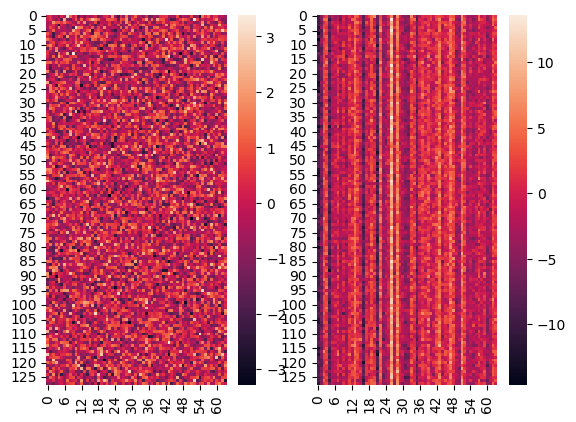

In [131]:
f, axes = plt.subplots(1, 2)

seaborn.heatmap(q[0], ax=axes[0])
seaborn.heatmap(out[0], ax=axes[1])
plt.show()